<a href="https://colab.research.google.com/github/JulieOnIsland/Machine_Learning/blob/main/DACON_news_topic_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DACON 뉴스 토픽 분류 AI 경진대회
* https://dacon.io/competitions/official/235747/overview/description 
* LSTM 사용
* Accuracy: 82%
* reference: https://wikidocs.net/44249

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Download and check the data

In [2]:
import pandas as pd
dpath = '/content/drive/MyDrive/data/dacon/news_topic_classification/'
train_df = pd.read_csv(dpath + 'train_data.csv')
train_df.head()

test_df = pd.read_csv(dpath + 'test_data.csv')
test_df.head()

,index,title
0,45654,유튜브 내달 2일까지 크리에이터 지원 공간 운영
1,45655,어버이날 맑다가 흐려져…남부지방 옅은 황사
2,45656,내년부터 국가RD 평가 때 논문건수는 반영 않는다
3,45657,김명자 신임 과총 회장 원로와 젊은 과학자 지혜 모을 것
4,45658,회색인간 작가 김동식 양심고백 등 새 소설집 2권 출간


In [3]:
train_df.head()

,index,title,topic_idx
0,0,인천→핀란드 항공기 결항…휴가철 여행객 분통,4
1,1,실리콘밸리 넘어서겠다…구글 15조원 들여 美전역 거점화,4
2,2,이란 외무 긴장완화 해결책은 미국이 경제전쟁 멈추는 것,4
3,3,NYT 클린턴 측근韓기업 특수관계 조명…공과 사 맞물려종합,4
4,4,시진핑 트럼프에 중미 무역협상 조속 타결 희망,4


In [5]:
!pip install konlpy

     |████████████████████████████████| 19.4 MB 1.3 MB/s 
     |████████████████████████████████| 448 kB 48.4 MB/s 


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Okt
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [7]:
train_df.head()

,index,title,topic_idx
0,0,인천→핀란드 항공기 결항…휴가철 여행객 분통,4
1,1,실리콘밸리 넘어서겠다…구글 15조원 들여 美전역 거점화,4
2,2,이란 외무 긴장완화 해결책은 미국이 경제전쟁 멈추는 것,4
3,3,NYT 클린턴 측근韓기업 특수관계 조명…공과 사 맞물려종합,4
4,4,시진핑 트럼프에 중미 무역협상 조속 타결 희망,4


In [9]:
len(train_df)

45654

In [8]:
train_df['title'].nunique()

45654

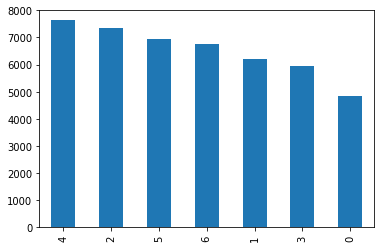

In [11]:
train_df['topic_idx'].value_counts().plot(kind='bar');

In [13]:
train_df.isnull().sum()

index        0
title        0
topic_idx    0
dtype: int64

In [19]:
train_df.loc[0]

index                               0
title        인천→핀란드 항공기 결항…휴가철 여행객 분통
topic_idx                           4
Name: 0, dtype: object

In [34]:
# 중복된 데이터 체크
train_df['title'].duplicated().sum()

0

# Preprocess the data

In [30]:
a_list=[]
for i in range(len(train_df)):
    if '…' in train_df['title'][i]:
        a_list.append(train_df.loc[i])


In [31]:
a_list

[]

In [29]:
train_df['title'] = train_df['title'].str.replace('…', '')
train_df.head()

,index,title,topic_idx
0,0,인천→핀란드 항공기 결항휴가철 여행객 분통,4
1,1,실리콘밸리 넘어서겠다구글 15조원 들여 美전역 거점화,4
2,2,이란 외무 긴장완화 해결책은 미국이 경제전쟁 멈추는 것,4
3,3,NYT 클린턴 측근韓기업 특수관계 조명공과 사 맞물려종합,4
4,4,시진핑 트럼프에 중미 무역협상 조속 타결 희망,4


In [35]:
# KoNLPy에서 제공하는 형태소 분석기 Okt 사용
okt = Okt()

In [36]:
train_df['title'].loc[0]

'인천→핀란드 항공기 결항휴가철 여행객 분통'

In [37]:
okt.morphs(train_df['title'].loc[0], stem=True)

['인천', '→', '핀란드', '항공기', '결항', '휴가', '철', '여행객', '분통']

In [39]:
X_train = []
for sentence in tqdm(train_df['title']):
    tokenized_sentence = okt.morphs(sentence, stem=True)
    stopwords_removed_sentence = [word for word in tokenized_sentence]
    X_train.append(stopwords_removed_sentence)

100%|██████████| 45654/45654 [02:12<00:00, 344.59it/s]


In [40]:
print(X_train[:3])

[['인천', '→', '핀란드', '항공기', '결항', '휴가', '철', '여행객', '분통'], ['실리콘밸리', '넘어서다', '구글', '15조원', '들이다', '美', '전역', '거점', '화'], ['이란', '외무', '긴장', '완화', '해결', '책', '은', '미국', '이', '경제', '전쟁', '멈추다', '것']]


In [41]:
X_test = []
for sentence in tqdm(test_df['title']):
    tokenized_sentence = okt.morphs(sentence, stem=True)
    stopwords_removed_sentence = [word for word in tokenized_sentence]
    X_test.append(stopwords_removed_sentence)

100%|██████████| 9131/9131 [00:19<00:00, 461.85it/s]


In [42]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [43]:
print(tokenizer.word_index)

{'에': 1, '·': 2, '하다': 3, '종합': 4, '의': 5, '서': 6, '로': 7, '2': 8, '한': 9, '도': 10, '명': 11, '이': 12, '대통령': 13, '은': 14, '3': 15, '1': 16, '美': 17, '한국': 18, '과': 19, '으로': 20, '들': 21, '北': 22, '5': 23, '전': 24, '는': 25, '위': 26, '가': 27, '기': 28, '첫': 29, '...': 30, '적': 31, '4': 32, '대': 33, '삼성': 34, '등': 35, '이란': 36, '보': 37, '되다': 38, '와': 39, '중': 40, '장': 41, '당': 42, '만에': 43, '출시': 44, '감독': 45, '中': 46, '주': 47, 'g': 48, '경기': 49, '없다': 50, '게시판': 51, 'lg': 52, '에서': 53, '제': 54, '트럼프': 55, '신간': 56, '것': 57, '문': 58, 'kt': 59, '보다': 60, '까지': 61, '안': 62, '朴': 63, '개': 64, '자': 65, '지': 66, '정부': 67, '투자': 68, '6': 69, '개발': 70, '8': 71, '대다': 72, '서울': 73, '고': 74, '부터': 75, '을': 76, 'sk': 77, '지원': 78, '화': 79, '원': 80, '10': 81, '내': 82, '최고': 83, '더': 84, '중국': 85, '올해': 86, '사': 87, '민주': 88, '개최': 89, '간': 90, '차': 91, '영업': 92, '연': 93, '7': 94, '회': 95, '현대': 96, '새': 97, '세계': 98, '미국': 99, '공개': 100, '日': 101, '일': 102, '기술': 103, '기업': 104, '최': 105, '성': 106, 

In [45]:
total_cnt = len(tokenizer.word_index)
total_cnt

31130

In [46]:
vocab_size = total_cnt + 1

In [47]:
tokenizer = Tokenizer(vocab_size)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [50]:
y_train=train_df['topic_idx'].to_numpy()
y_train

array([4, 4, 4, ..., 1, 2, 2])

In [52]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                  stratify=y_train,
                                                  test_size=0.2)

In [56]:
print(y_train.shape, y_val.shape)

(36523,) (9131,)


In [57]:
X_train[:3]

[[97, 785, 6270, 509, 11786, 1145, 3590, 302, 312, 2293, 344, 18, 42, 4],
 [22, 3915, 20, 3085, 9350, 6027, 11509, 223, 2500],
 [52, 754, 52, 48, 69, 44]]

In [58]:
X_val[:3]

[[335, 345, 6511, 305, 538, 565, 110, 6056, 910, 39, 4695, 1357],
 [4203, 17, 36, 987, 2099, 1590, 502, 71, 843, 6145, 31, 4385, 698, 158, 4],
 [336, 13, 974, 1, 125, 192, 1982, 140, 1516]]

In [77]:
len_list=[]
for i in range(len(X_train)):
    len_list.append(len(X_train[i]))

In [78]:
max(len_list)

21

In [76]:
val_len_list=[]
for i in range(len(X_val)):
    val_len_list.append(len(X_val[i]))

In [79]:
max(val_len_list)

19

In [80]:
max_len=21

In [81]:
test_len_list=[]
for i in range(len(X_test)):
    test_len_list.append(len(X_test[i]))

In [82]:
max(test_len_list)

19

In [83]:
X_train = pad_sequences(X_train, maxlen=max_len)
X_val = pad_sequences(X_val, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [84]:
vocab_size

31131

In [85]:
train_df['topic_idx'].unique()

array([4, 6, 5, 0, 1, 3, 2])

# Build the model

In [86]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(7, activation='softmax'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=2, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=2, save_best_only=True)

model.compile(optimizer='Adam', loss='sparse_categorical_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=5, callbacks=[es, mc], batch_size=64, 
                    validation_data=(X_val, y_val))

Epoch 1/5
569/571 [============================>.] - ETA: 0s - loss: 0.7755 - acc: 0.7287
Epoch 1: val_acc improved from -inf to 0.84076, saving model to best_model.h5
571/571 [==============================] - 21s 16ms/step - loss: 0.7752 - acc: 0.7288 - val_loss: 0.4933 - val_acc: 0.8408
Epoch 2/5
571/571 [==============================] - ETA: 0s - loss: 0.2790 - acc: 0.9098
Epoch 2: val_acc improved from 0.84076 to 0.84405, saving model to best_model.h5
571/571 [==============================] - 7s 13ms/step - loss: 0.2790 - acc: 0.9098 - val_loss: 0.5124 - val_acc: 0.8440
Epoch 3/5
567/571 [============================>.] - ETA: 0s - loss: 0.1521 - acc: 0.9510
Epoch 3: val_acc did not improve from 0.84405
571/571 [==============================] - 7s 12ms/step - loss: 0.1527 - acc: 0.9509 - val_loss: 0.5423 - val_acc: 0.8335
Epoch 4/5
570/571 [============================>.] - ETA: 0s - loss: 0.0959 - acc: 0.9695
Epoch 4: val_acc did not improve from 0.84405
571/571 [=============

In [87]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_val, y_val)[1]))

286/286 [==============================] - 3s 6ms/step - loss: 0.5124 - acc: 0.8440

 테스트 정확도: 0.8440


In [92]:
preds=loaded_model.predict(X_test)
preds[:5]

array([[1.3716909e-02, 5.6062458e-04, 4.6677378e-01, 5.1366562e-01,
        1.6958353e-03, 1.6168192e-04, 3.4255278e-03],
       [9.2490000e-06, 2.2308825e-06, 1.8696605e-04, 9.9954212e-01,
        2.2694689e-05, 2.0327610e-04, 3.3539836e-05],
       [7.6815687e-02, 6.3124835e-02, 7.3044407e-01, 1.4570016e-02,
        5.6524626e-03, 1.0923956e-03, 1.0830050e-01],
       [6.2318105e-01, 7.4674390e-02, 2.7129009e-01, 1.5245107e-02,
        7.8346767e-03, 2.1764683e-03, 5.5982489e-03],
       [1.5858974e-05, 1.4883258e-07, 2.4927608e-04, 9.9972719e-01,
        2.7306123e-06, 2.3825685e-06, 2.3942396e-06]], dtype=float32)

In [93]:
len(preds)

9131

In [94]:
len(test_df)

9131

In [90]:
preds[0].argmax()

3

In [95]:
total_preds=np.argmax(preds, axis=1)

In [96]:
total_preds

array([3, 3, 2, ..., 3, 0, 6])

## Submission

In [105]:
submission = pd.read_csv('/content/drive/MyDrive/data/dacon/news_topic_classification/sample_submission.csv')

In [114]:
path = '/content/drive/MyDrive/data/dacon/news_topic_classification/sample_submission.csv'

In [98]:
submission.head()

,index,topic_idx
0,45654,0
1,45655,0
2,45656,0
3,45657,0
4,45658,0


In [109]:
submission.topic_idx = total_preds

In [115]:
submission.head()

,index,topic_idx
0,45654,3
1,45655,3
2,45656,2
3,45657,0
4,45658,3


In [112]:
submission

,index,topic_idx
0,45654,3
1,45655,3
2,45656,2
3,45657,0
4,45658,3
...,...,...
9126,54780,3
9127,54781,2
9128,54782,3
9129,54783,0


In [116]:
submission.to_csv(path, index=False)

# The END